## Multi-class dog breed classification
Building a multi-class image classiier using Tensorflow 2.0 and Tensorflow hub.

### 1. Problem
Identify dog breed given a image of dog.

### 2. Data
The data is from Kaggle's "dog breed identification" competition.
https://www.kaggle.com/competitions/dog-breed-identification/

### 3. Evaluation
The evaluation metric is a file which contains the prediction probabilities of each test image.
https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

### 4. Features
Some information about data:


*   We are dealing with unstructured data (images) so we will be using deep learning
*   There are 120 different breeds (so 120 classes)
*   There are 10,000+ images in training set(has labels)
*   There are 10,000+ images in test set(no labesl)




In [ ]:
# Unzip the data
# !unzip "/content/drive/MyDrive/Colab data/dog-breed-identification.zip" -d "/content/drive/MyDrive/Colab data"

## Getting the workspace ready

* Import tensorflow
* Import tensorflow hub
* Make sure using GPU

In [ ]:
import tensorflow as tf
print("TF Version:", tf.__version__)

import tensorflow_hub as hub
print("Hub Version:", hub.__version__)

# Check GPU availability
print("GPU", "available!" if tf.config.list_physical_devices("GPU") else "not available.")

TF Version: 2.8.2
Hub Version: 0.12.0
GPU available!


In [ ]:
!nvidia-smi

Thu Jun  9 11:37:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Getting the data ready

Will all machine learning models, the data has to be in numerical format so we will be turning our images into tensors (numeric representations).

Starting with checking the labels

In [ ]:
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Colab data/labels.csv")

labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


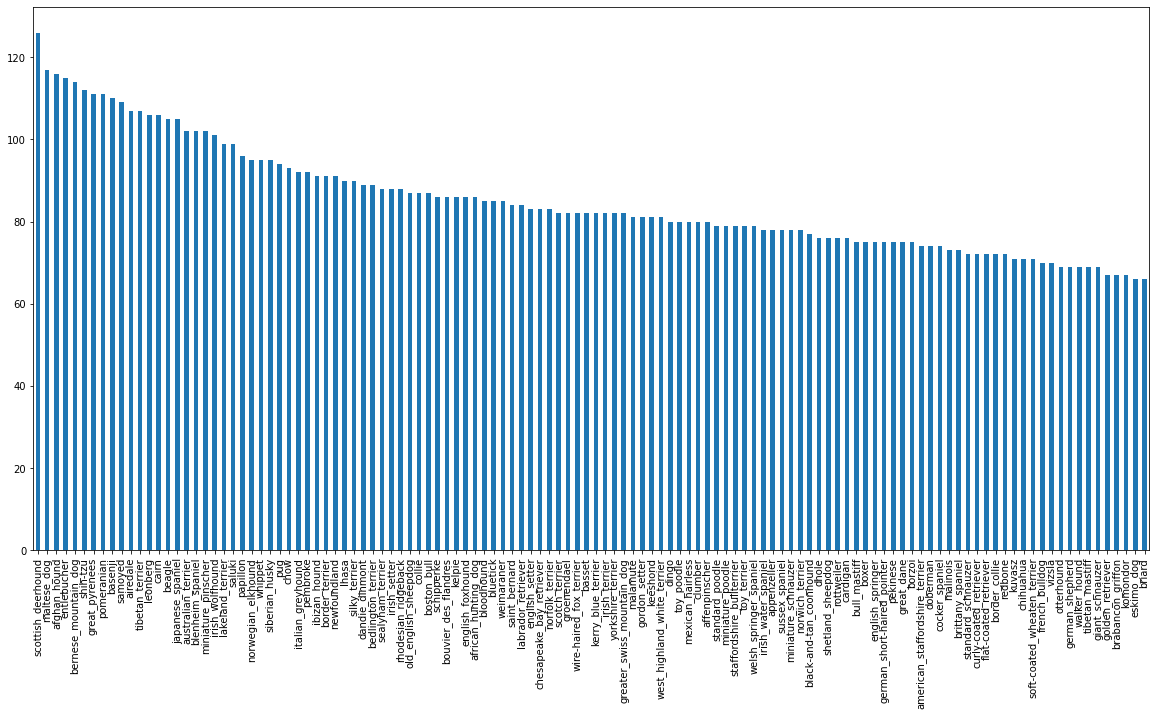

In [ ]:
# Checking how many samples are there for each breed

labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

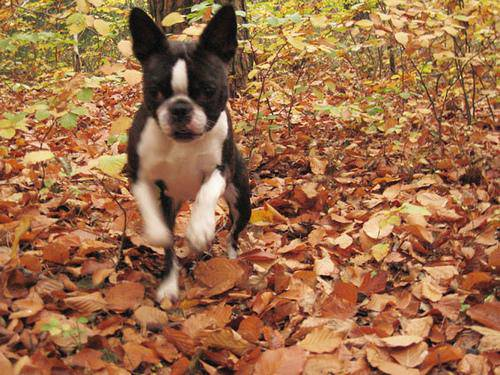

In [ ]:
# View a image
from IPython.display import Image
Image("drive/MyDrive/Colab data/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Making a list of image file pathnames

In [ ]:
# Creating pathnames from file ID's

filenames = ["drive/MyDrive/Colab data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

filenames[:10]

['drive/MyDrive/Colab data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Colab data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Colab data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Colab data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Colab data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Colab data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Colab data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Colab data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Colab data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Colab data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
len(filenames)

10222

In [ ]:
# Cheking if filename count is the same as file count

import os
if len(os.listdir("drive/MyDrive/Colab data/train")) == len(filenames):
  print("Matched")

Matched


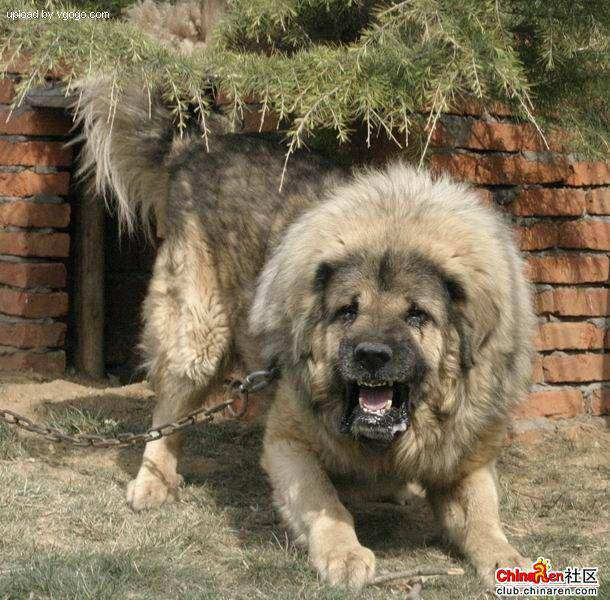

In [ ]:
# One more check

Image(filenames[9000])

In [ ]:
labels = labels_csv['breed']
import numpy as np
labels = np.array(labels)

In [ ]:
if len(labels) == len(filenames):
  print("Match")

Match


In [ ]:
unique_breeds = np.unique(labels)

In [ ]:
len(unique_breeds)

120

In [ ]:
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
# Turn every label into a boolean array in order to then convert the bool arr to a numeric arrray

boolean_labels = [label == unique_breeds for label in labels]

In [ ]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
## Creating a validation set from the training set
# Setup X and y

X = filenames
y = boolean_labels

We are going to start with the first thousand images instead of all 10k+ to speed up development

In [ ]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
X_train[:2], y_train[:2]

(['drive/MyDrive/Colab data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Colab data/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fal

### Preprocessing Images (turning images into Tensors)

Writing a function which will:
1. Take an image filepath as input
2. Use Tensorflow to read the file and size it to var ```image```
3. Turn out ```image``` into Tensor
4. Normalize the colour channel values (0-255 to 0-1)
5. Resize the image to shape of (224, 224)
6. Return the modified image

In [ ]:
# Conver a image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
len(image), image.shape

(257, (257, 350, 3))

In [ ]:
# Turn image into a tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [ ]:
# Create a function for preprocessing images

IMG_SIZE = 224

def process_images(image_path):

  # Read an image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 colour channels
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the colour channel values from 0-255 to 0-1 (Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

The data needs to be in form of Tensor tuples which look like (image, label)


In [ ]:
# Create a function to return a Tuple of tensors
def get_image_label(image_path, label):
  image = process_images(image_path)
  return image, label

In [ ]:
# Define a batch size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label(y) pairs.
  Shuffles the data if its training data but does not shuffle if it's validation data
  Also accepts test data as input
  """
  # IF the data is test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepaths, no labels
    data_batch = data.map(process_images).batch(BATCH_SIZE)
    print("done!")
    return data_batch

  # If the data is validation dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    print("done!")
    return data_batch

  # If traing data
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    # Shuffle the data
    data = data.shuffle(buffer_size = len(X))

    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    print("done!")
    return data_batch

In [ ]:
# Creating training and validation sets

train_data = create_data_batches(X_train, y_train)

val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
done!
Creating validation data batches...
done!


In [ ]:
len(train_data)

25

## Visualize Data Batches

In [ ]:
import matplotlib.pyplot as plt

# A function to show images in a data batch

def show_25_images (images, labels):

  # Setup the figure
  plt.figure(figsize=(10,10))

  # Loop throught 25 images
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    # Add image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gridlines off
    plt.axis("off")


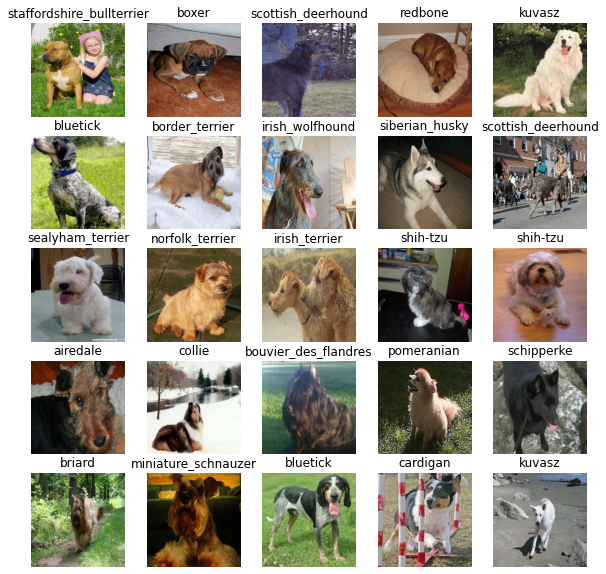

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [ ]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

## Bulding a shape

Before we build a model, we need to define:
* The input shape (our images shape, in the form of tensors)
* The output shape (image labels, in the form of tensors)
* The URL of model we want to use (cuz we are using transfer learning and not making a moel from scratch)

In [ ]:
IMG_SIZE

224

In [ ]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # Batch, Height, Width, Colour

OUTPUT_SHAPE = len(unique_breeds)

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Using inputs, outputs and model to make a keras deep learning model

Function:
1. Take input shape, output shape, and model
2. Define the layers in Keras model in sequential fashion.
3. Compile the model
4. Builds the model
5. Return the model

In [ ]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):

  print("Building model with:", MODEL_URL)
  # Setup model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), 
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax")
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )


  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Tensorflow callback

Callbacks are helper functions which a model can use during training to do things like saving progress, check its progress, or stop training early if a model stops imporving

Tensorboard callback

In [ ]:
# Tensorboard callback helps track model progress
#1 Load tensorboard extension
%load_ext tensorboard

In [ ]:
#2 Create tensorboard callback which will save logs to a directory and pass it to our models `fit()` function
import datetime

def create_tensorboard_callback():
  # Create a log  folder
  logdir = os.path.join("drive/MyDrive/Colab data/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

Early stopping callback

In [ ]:
# Early stopping callback helps in stopping training and prevents overfitting when a certain metric stops improving

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model

Our first model will only train on 1000 images ( subset) to make sure everything is working.

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100}

In [ ]:
# Creating function to train a model

def train_model():
  model = create_model()

  # Creat a new Tensorboard session everytime we train a new model
  tensorboard= create_tensorboard_callback()

  # Fit the model

  model.fit(x=train_data,
            epochs= NUM_EPOCHS,
            validation_data = val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # Return the fitted model
  return model

In [ ]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 366s 14s/step - loss: 4.6001 - accuracy: 0.0950 - val_loss: 3.4591 - val_accuracy: 0.1950
Epoch 2/100
25/25 [==============================] - 4s 160ms/step - loss: 1.6312 - accuracy: 0.7100 - val_loss: 2.2410 - val_accuracy: 0.4900
Epoch 3/100
25/25 [==============================] - 4s 141ms/step - loss: 0.5511 - accuracy: 0.9475 - val_loss: 1.7081 - val_accuracy: 0.5900
Epoch 4/100
25/25 [==============================] - 4s 162ms/step - loss: 0.2449 - accuracy: 0.9900 - val_loss: 1.5270 - val_accuracy: 0.6200
Epoch 5/100
25/25 [==============================] - 4s 155ms/step - loss: 0.1443 - accuracy: 0.9962 - val_loss: 1.4328 - val_accuracy: 0.6500
Epoch 6/100
25/25 [==============================] - 4s 140ms/step - loss: 0.0986 - accuracy: 1.0000 - val_loss: 1.3908 - val_accuracy: 0.6550
Epoch 7/100
25/25 [==============================

In [ ]:
# Checking Tensorboard logs

%tensorboard --logdir drive/MyDrive/Colab\ data/logs

## Making predictions using trained model


We wil use validation data as it was not used to train on and it is already in the required form



In [ ]:
predictions = model.predict(val_data, verbose=1)

7/7 [==============================] - 1s 98ms/step


In [ ]:
predictions

array([[1.9009702e-03, 9.3963870e-05, 9.6421642e-04, ..., 4.3834015e-04,
        1.1281312e-04, 8.8737644e-03],
       [6.3449773e-03, 8.0770603e-04, 1.1404721e-02, ..., 2.0214941e-03,
        1.8729521e-02, 2.2282035e-03],
       [7.4295691e-05, 4.1550060e-04, 7.1218710e-05, ..., 4.3281936e-04,
        6.6148423e-05, 6.2609375e-05],
       ...,
       [2.9880382e-06, 9.3492570e-05, 2.6215866e-04, ..., 2.2678194e-05,
        6.6593831e-04, 2.1432823e-05],
       [5.5955071e-03, 2.8851186e-04, 5.3877314e-04, ..., 1.8704645e-04,
        1.1748825e-04, 4.5196585e-02],
       [1.1890347e-04, 6.8894507e-05, 3.7295237e-04, ..., 7.5607421e-04,
        7.1039272e-04, 7.3905692e-05]], dtype=float32)

In [ ]:
predictions # Softmax function outputs probabilities between 0 and 1 where all the predictions add up to 1

In [ ]:
predictions.shape

(200, 120)

In [ ]:
predictions[0], len(predictions[0])

(array([1.90097024e-03, 9.39638703e-05, 9.64216422e-04, 6.03245317e-05,
        3.43329477e-04, 1.76236135e-05, 3.79873626e-02, 4.41472745e-04,
        1.97746733e-04, 3.16201872e-03, 1.76372414e-04, 3.32349271e-04,
        4.32675093e-04, 5.74360638e-05, 3.73207731e-04, 9.23526182e-04,
        1.24226353e-04, 1.23289451e-01, 4.84053271e-05, 2.53596663e-04,
        1.31257030e-03, 5.20624686e-04, 1.47096680e-05, 5.94812853e-04,
        4.28930274e-04, 9.49987952e-05, 1.23188838e-01, 3.83015897e-04,
        1.75307889e-03, 7.57572067e-04, 5.29129793e-05, 1.80498837e-03,
        7.43307988e-04, 2.41961898e-05, 6.24146662e-04, 3.88078727e-02,
        9.19629201e-06, 7.13590300e-04, 2.70587188e-04, 5.80493419e-04,
        1.21363229e-03, 1.09568842e-04, 1.60315234e-04, 5.36739419e-04,
        1.65694277e-04, 4.26133658e-04, 1.21265002e-04, 8.43999849e-04,
        2.45942239e-04, 8.31852376e-05, 2.66956456e-04, 3.99519013e-05,
        6.41283288e-04, 4.43840137e-04, 4.54723573e-04, 2.681995

In [ ]:
np.max(predictions[0]), np.argmax(predictions[0]), unique_breeds[np.argmax([predictions[0]])]

(0.22344595, 103, 'soft-coated_wheaten_terrier')

In [ ]:
# Turn prediction probabilites into their respective label

def get_pred_label(predictions):
  return unique_breeds[np.argmax(predictions)]

In [ ]:
pred_label = get_pred_label(predictions[32])
pred_label

'walker_hound'

Our validation data is still in batch format so we will unbatch it and then make predictions on the images and compare them to truth labels

In [ ]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Function to unbatch dataset

images_ = []
labels_ = []

for image , label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

In [ ]:
len(labels_)

200

In [ ]:
get_pred_label(labels_[0])

'cairn'

In [ ]:
get_pred_label(predictions[0])

'soft-coated_wheaten_terrier'

In [ ]:
def unbatchify(data):
  images=[]
  labels=[]

  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels



In [ ]:
val_images, val_labels = unbatchify(val_data)

In [ ]:
val_labels[0]

'cairn'

### Now we will visualize the prediction to better understand our model

We have:
* Predicted labels (on validation images)
* Validation True labels 
* Validation images

### Writing a new function which will:
1. Take a array of predictions probabilities, array of truth labels, and array of images and a integer
2. Convert prediction probabilities to the prediction label with max probability
3. Plot predicted label, its probability, the truth label and the image.

In [ ]:
def plot_pred(predictions, labels, images, n=9):
  pred_label = get_pred_label(predictions[n])

  if pred_label == labels[n]:
    color ="green"
  else:
    color ="red"

  plt.imshow(images[n])
  plt.xticks([])
  plt.yticks([])

  #Title with predicted label, its probab, and truth label
  plt.title("{} {:2.0f}% {}". format(pred_label, np.max(predictions[n]*100), labels[n]), color=color)

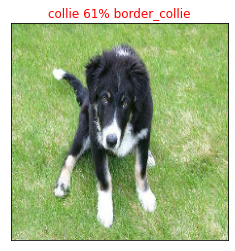

In [ ]:
plot_pred(predictions=predictions, labels=val_labels, images=val_images)

In [ ]:
np.max(predictions[35])

Now we will write a function which will visualize top 10 predictions

This function will:
* Take input of prediction probabilities array and a truth array and a integer
* Find the prediction using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green

In [ ]:
def plot_pred_conf(predictions, labels, n=1):
  # Plots top 10 highest prediction probabilities along with truth label for sample n
  pred_prob, true_label = predictions[n], labels[n]

  # Get predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  
  # Find the top 10 prediction values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the labels for top 10 predictions
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]


  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change the color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass
     

In [ ]:
predictions[0]

array([1.90097024e-03, 9.39638703e-05, 9.64216422e-04, 6.03245317e-05,
       3.43329477e-04, 1.76236135e-05, 3.79873626e-02, 4.41472745e-04,
       1.97746733e-04, 3.16201872e-03, 1.76372414e-04, 3.32349271e-04,
       4.32675093e-04, 5.74360638e-05, 3.73207731e-04, 9.23526182e-04,
       1.24226353e-04, 1.23289451e-01, 4.84053271e-05, 2.53596663e-04,
       1.31257030e-03, 5.20624686e-04, 1.47096680e-05, 5.94812853e-04,
       4.28930274e-04, 9.49987952e-05, 1.23188838e-01, 3.83015897e-04,
       1.75307889e-03, 7.57572067e-04, 5.29129793e-05, 1.80498837e-03,
       7.43307988e-04, 2.41961898e-05, 6.24146662e-04, 3.88078727e-02,
       9.19629201e-06, 7.13590300e-04, 2.70587188e-04, 5.80493419e-04,
       1.21363229e-03, 1.09568842e-04, 1.60315234e-04, 5.36739419e-04,
       1.65694277e-04, 4.26133658e-04, 1.21265002e-04, 8.43999849e-04,
       2.45942239e-04, 8.31852376e-05, 2.66956456e-04, 3.99519013e-05,
       6.41283288e-04, 4.43840137e-04, 4.54723573e-04, 2.68199568e-04,
      

In [ ]:
predictions[0].argsort()[-10:][::-1] # The indexes of top 10 prediction values for pred[0]

array([103,  17,  26, 106,  59,  65,  35,   6,  73, 102])

In [ ]:
predictions[0][predictions[0].argsort()[-10:][::-1]] # The top 10 prediction values for pred[0]

array([0.22344595, 0.12328945, 0.12318884, 0.06031347, 0.05367769,
       0.05116442, 0.03880787, 0.03798736, 0.03015718, 0.0270649 ],
      dtype=float32)

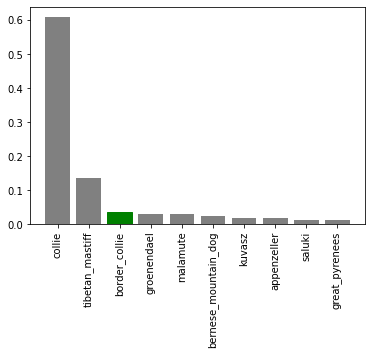

In [ ]:
plot_pred_conf(predictions, val_labels, n=9)

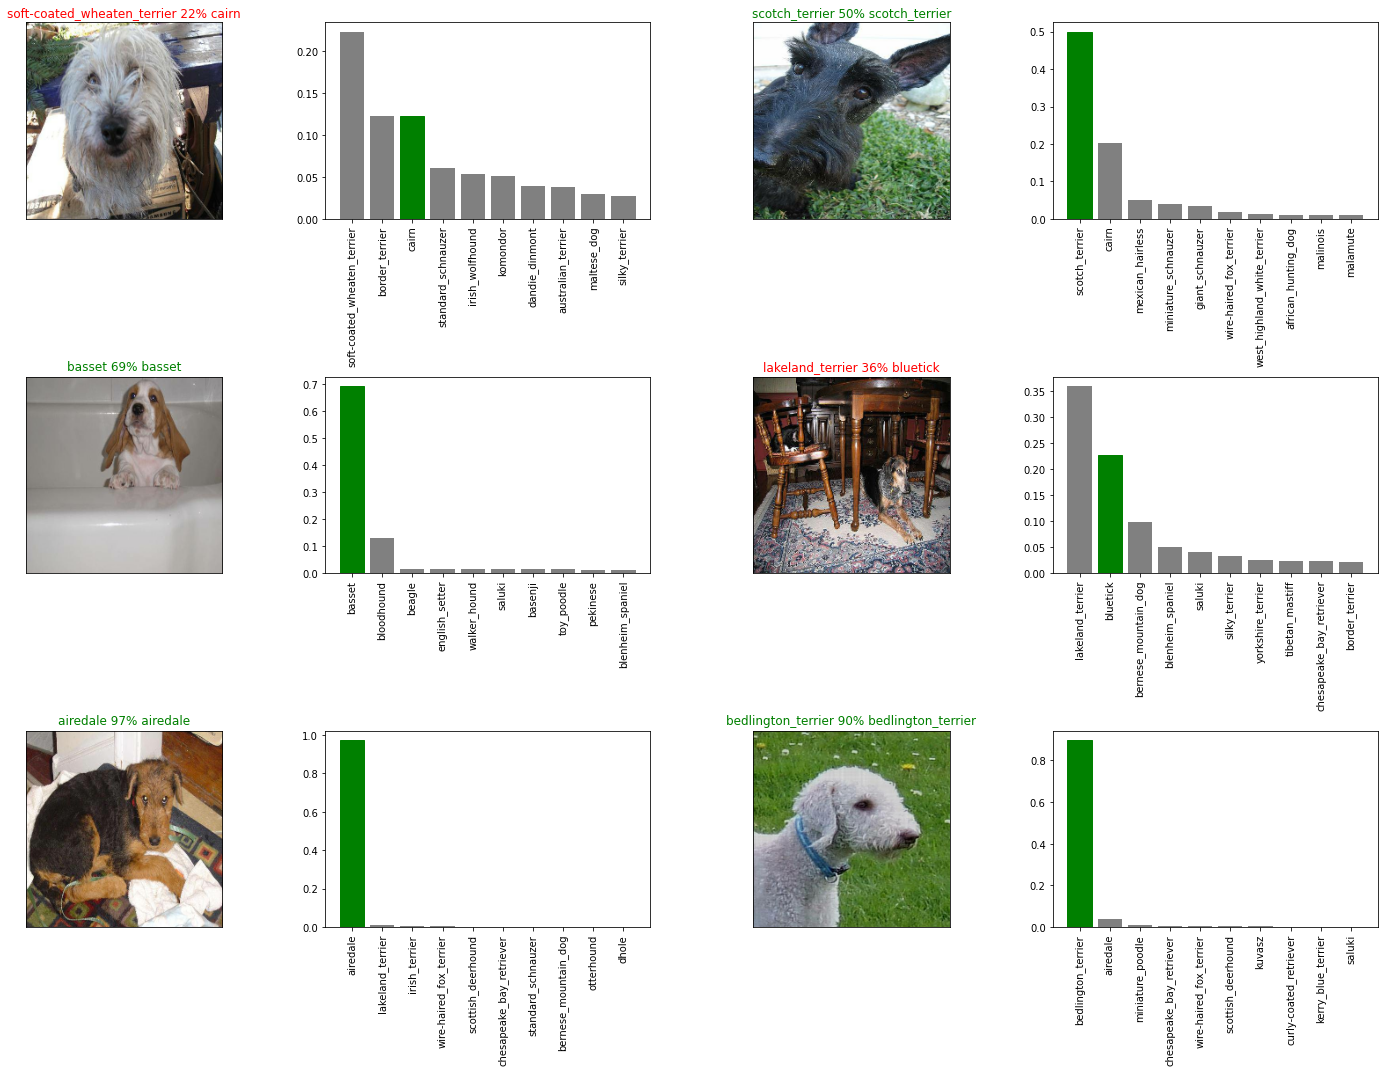

In [ ]:
# Using the above two functions to visualize more samples

i_multiplier = 0
rows = 3
cols =2
images = rows * cols

plt.figure(figsize=(10*cols, 5*rows))
for i in range(images):
  plt.subplot(rows, 2*cols, 2*i+1)
  plot_pred(predictions, val_labels, val_images, n=i+i_multiplier)
  plt.subplot(rows, 2*cols, 2*i+2)
  plot_pred_conf(predictions, val_labels, n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Training the model on full dataset

In [ ]:
full_data = create_data_batches(X,y)

Creating training data batches...
done!


In [ ]:
len(y)

10222

In [ ]:
# Create a model

full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [ ]:
# Create callbacks

full_model_tensorboard = create_tensorboard_callback()

full_model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                        patience = 3)

In [ ]:
# Fit the model to data

full_model.fit(x = full_data,
              epochs= NUM_EPOCHS,
              callbacks= [full_model_tensorboard, full_model_early_stop])

Epoch 1/100
320/320 [==============================] - 3435s 11s/step - loss: 1.3397 - accuracy: 0.6734
Epoch 2/100
320/320 [==============================] - 37s 115ms/step - loss: 0.4013 - accuracy: 0.8814
Epoch 3/100
320/320 [==============================] - 40s 123ms/step - loss: 0.2384 - accuracy: 0.9345
Epoch 4/100
320/320 [==============================] - 40s 126ms/step - loss: 0.1538 - accuracy: 0.9646
Epoch 5/100
320/320 [==============================] - 40s 123ms/step - loss: 0.1071 - accuracy: 0.9778
Epoch 6/100
320/320 [==============================] - 41s 127ms/step - loss: 0.0782 - accuracy: 0.9863
Epoch 7/100
320/320 [==============================] - 41s 127ms/step - loss: 0.0593 - accuracy: 0.9912
Epoch 8/100
320/320 [==============================] - 41s 129ms/step - loss: 0.0462 - accuracy: 0.9938
Epoch 9/100
320/320 [==============================] - 42s 131ms/step - loss: 0.0381 - accuracy: 0.9960
Epoch 10/100
320/320 [==============================] - 39s 123m

In [ ]:
def save_model (model, suffix=None):
  modeldir = os.path.join("drive/MyDrive/Colab data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  
  modelpath = modeldir + "-" + suffix + ".h5"
  print(f"Saving model to {modelpath}")
  model.save(modelpath)
  return modelpath

In [ ]:
save_model(full_model, suffix="full_imageset_mobilenetv2_Adam")

Saving model to drive/MyDrive/Colab data/models/20220530-08501653900632-full_imageset_mobilenetv2_Adam.h5


'drive/MyDrive/Colab data/models/20220530-08501653900632-full_imageset_mobilenetv2_Adam.h5'

In [ ]:
!nvidia-smi

Mon May 30 07:31:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    28W /  70W |   8938MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
save_model(model, suffix="train_imageset_mobilenetv2_Adam")

Saving model to drive/MyDrive/Colab data/models/20220530-07321653895961-train_imageset_mobilenetv2_Adam.h5


'drive/MyDrive/Colab data/models/20220530-07321653895961-train_imageset_mobilenetv2_Adam.h5'

In [ ]:
def load_model(modelpath):
  print(f"Loading model from {modelpath}")

  model = tf.keras.models.load_model(modelpath,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
  return model

In [ ]:
model = load_model("/content/drive/MyDrive/Colab data/models/20220530-07321653895961-train_imageset_mobilenetv2_Adam.h5")

Loading model from /content/drive/MyDrive/Colab data/models/20220530-07321653895961-train_imageset_mobilenetv2_Adam.h5


In [ ]:
loaded_full_model = load_model("/content/drive/MyDrive/Colab data/models/20220530-08501653900632-full_imageset_mobilenetv2_Adam.h5")

Loading model from /content/drive/MyDrive/Colab data/models/20220530-08501653900632-full_imageset_mobilenetv2_Adam.h5


# Making predictions on test data

The test data needs to be in the same format as the format in which the model was trained (tensor batches). We will use the create_data_batches() function that we wrote earlier to do this.

Steps to do:
1. Get the test data filenames
2. Convert to batches using the function.
3. Make predictions by calling predict() method on the model.

In [ ]:
# Getting filenames
test_path= "/content/drive/MyDrive/Colab data/test/"
import os
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['/content/drive/MyDrive/Colab data/test/e0e3eb01e80b1d694a47b23909e158ec.jpg',
 '/content/drive/MyDrive/Colab data/test/e64b53f9c0fefdd97e269c55335418e7.jpg',
 '/content/drive/MyDrive/Colab data/test/e0d51afc60c25eb2205be1644af09cc5.jpg',
 '/content/drive/MyDrive/Colab data/test/e061b8d24e7b1324a6ac92ae81fdda19.jpg',
 '/content/drive/MyDrive/Colab data/test/deb063345bf2b6752e2fe25cad096547.jpg',
 '/content/drive/MyDrive/Colab data/test/e683ba5a138de0fbb7bb1523862b43f2.jpg',
 '/content/drive/MyDrive/Colab data/test/e648a16d81b6441658b77bca0f1be4ee.jpg',
 '/content/drive/MyDrive/Colab data/test/e062ea256ada165dfe998fbc6529dff7.jpg',
 '/content/drive/MyDrive/Colab data/test/dcc047e682db75bbcebdec2288192f1d.jpg',
 '/content/drive/MyDrive/Colab data/test/dd5c5652d5d34e922af98c9b0295d909.jpg']

In [ ]:
len(test_filenames)

10357

In [ ]:
# Convert test data to batches
test_data= create_data_batches(test_filenames, test_data=True)

Creating test data batches...
done!


In [ ]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
#3 Predict
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 3819s 12s/step


In [ ]:
# Save the above predictions to a csv file 
import numpy as np
np.savetxt("drive/MyDrive/Colab data/preds_array.csv", test_predictions, delimiter=",")

In [ ]:
test_predictions = np.loadtxt("drive/MyDrive/Colab data/preds_array.csv", delimiter=",")

In [ ]:
len(test_predictions)

10357

In [ ]:
test_predictions[:10]

array([[2.52349448e-08, 4.95584891e-06, 2.56114552e-09, ...,
        1.68488327e-07, 1.81562188e-09, 4.49369031e-09],
       [2.03115142e-08, 3.23203270e-11, 1.58346751e-07, ...,
        1.51527928e-08, 1.15396919e-08, 1.07942913e-06],
       [5.69802729e-08, 1.26665137e-10, 2.73952822e-12, ...,
        4.21830570e-09, 1.54064678e-10, 1.92004590e-09],
       ...,
       [1.47539880e-09, 1.18146552e-07, 1.42205886e-06, ...,
        9.11122219e-11, 3.54812713e-08, 1.11007374e-07],
       [7.54833252e-07, 1.30219405e-10, 2.80341549e-11, ...,
        1.00113944e-08, 1.06987175e-09, 1.16746235e-09],
       [6.85726779e-12, 1.45547636e-11, 5.82505493e-07, ...,
        2.40542158e-05, 8.34073956e-12, 1.62290293e-14]])

In [ ]:
test_predictions.shape

(10357, 120)

### Making a submission to kaggle

Looking at Kaggles sample submission, we find that it wants our models prediction preobability outputs in a DataFrame with an ID and a column for each different do breed.

To do this, we will:
* Create a pandas DataFrame with ID column as well as a column for each data breed
* Add data to their ID column by extracting the test image ID's from their filepaths
* Add data (prediction probabilities) to each of the dog breed columns.
* Export DataFrame as a CSV to submit to Kaggle.


In [ ]:
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))

In [ ]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [ ]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [ ]:
preds_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e0e3eb01e80b1d694a47b23909e158ec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e64b53f9c0fefdd97e269c55335418e7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e0d51afc60c25eb2205be1644af09cc5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e061b8d24e7b1324a6ac92ae81fdda19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,deb063345bf2b6752e2fe25cad096547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,0716b7a11a2dd4141f3f1a8aa14eea2d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10353,07e56f8e36196be69405e4c524c99b98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10354,08f4ff17cc6bf754d798eb3b39fafebe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10355,08152b214c5b628d9e70f609230fd51c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Add the prediction probabilities to each dog breed column.
preds_df[list(unique_breeds)] = test_predictions
preds_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e0e3eb01e80b1d694a47b23909e158ec,2.523494e-08,4.955849e-06,2.561146e-09,5.906391e-10,9.809527e-09,3.369686e-08,4.297219e-09,1.780270e-09,6.522820e-10,...,4.542392e-07,1.087735e-08,3.316169e-10,2.201279e-08,1.609407e-06,8.327456e-10,1.026371e-10,1.684883e-07,1.815622e-09,4.493690e-09
1,e64b53f9c0fefdd97e269c55335418e7,2.031151e-08,3.232033e-11,1.583468e-07,4.146499e-11,2.195832e-06,1.244975e-07,1.395509e-07,9.975332e-01,2.962626e-09,...,9.305052e-06,2.808777e-04,3.381350e-08,3.677875e-09,2.065526e-09,4.120549e-09,3.871488e-09,1.515279e-08,1.153969e-08,1.079429e-06
2,e0d51afc60c25eb2205be1644af09cc5,5.698027e-08,1.266651e-10,2.739528e-12,3.448303e-09,3.672508e-12,9.297117e-11,3.886430e-11,4.776485e-09,1.129878e-09,...,7.232663e-08,6.382528e-10,1.703022e-11,2.460531e-08,3.692953e-09,3.963983e-11,4.575800e-06,4.218306e-09,1.540647e-10,1.920046e-09
3,e061b8d24e7b1324a6ac92ae81fdda19,1.441889e-08,4.255816e-08,3.765522e-08,1.896291e-10,1.445377e-09,1.148942e-07,3.435675e-08,4.004038e-07,6.408364e-11,...,4.130970e-09,3.523958e-08,2.816802e-10,1.845505e-09,9.074958e-09,8.886112e-10,1.429503e-08,3.827618e-10,3.486579e-08,1.063509e-08
4,deb063345bf2b6752e2fe25cad096547,6.781012e-07,8.799773e-10,1.724510e-09,3.021966e-12,2.184488e-09,6.181044e-13,6.832485e-08,3.010967e-11,7.677387e-11,...,9.354427e-08,3.624882e-07,1.372274e-09,6.439607e-11,3.603493e-10,7.576370e-12,3.885157e-07,2.684315e-11,2.106530e-07,2.454512e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,0716b7a11a2dd4141f3f1a8aa14eea2d,3.449992e-04,2.074766e-09,1.020520e-06,4.400990e-10,4.229321e-08,4.270975e-10,7.570186e-06,2.236193e-09,6.239426e-09,...,5.228194e-08,2.282798e-07,2.591476e-10,4.637251e-09,2.245996e-11,3.258999e-10,1.445524e-05,2.956040e-08,1.058370e-06,5.327908e-07
10353,07e56f8e36196be69405e4c524c99b98,2.259861e-08,1.237782e-06,5.080291e-02,2.336340e-06,7.047465e-07,1.324814e-08,5.621851e-08,1.718458e-07,2.644221e-07,...,1.102936e-07,8.951058e-08,3.602455e-08,8.829137e-09,1.911775e-08,2.090603e-08,1.393346e-08,1.725928e-07,1.800666e-07,7.431396e-08
10354,08f4ff17cc6bf754d798eb3b39fafebe,8.137824e-11,5.273343e-10,8.261556e-09,9.530009e-11,3.430847e-10,5.009984e-11,5.121841e-11,1.706352e-09,4.860617e-10,...,2.879237e-11,3.261962e-11,1.546729e-10,2.665471e-11,3.638116e-10,1.272821e-11,1.845241e-10,4.820368e-12,1.004573e-10,1.689872e-10
10355,08152b214c5b628d9e70f609230fd51c,1.594474e-11,2.399299e-07,3.024399e-09,1.737208e-02,1.618184e-09,6.545462e-07,2.211648e-05,7.637769e-10,1.573838e-11,...,5.398559e-10,1.444955e-09,1.533848e-07,9.397040e-09,5.753111e-07,1.276529e-07,5.342752e-10,6.853945e-08,6.854269e-05,5.957000e-07


In [ ]:
preds_df.to_csv("drive/MyDrive/Colab data/model_predictions_submission.csv",
                index=False)

from operator import methodcaller
### Making predictions on custom images

Steps:
1. Get filepaths
2. Turn filepaths into data batches using our fn and settings test_data=true since we don't have a label
3. Pass the custom data batch to models predict() method
4. Convert pred probab to labels

5. Compare labesl to image

In [ ]:
# Get custom image filepaths
custom_path = "drive/MyDrive/Colab data/my-dog-photos/"

custom_image_path = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_path

['drive/MyDrive/Colab data/my-dog-photos/3.JPG',
 'drive/MyDrive/Colab data/my-dog-photos/4.jpg',
 'drive/MyDrive/Colab data/my-dog-photos/2.JPG',
 'drive/MyDrive/Colab data/my-dog-photos/1.JPG']

In [ ]:
# Turn custom images into batch
custom_data = create_data_batches(custom_image_path, test_data=True)
custom_data

Creating test data batches...
done!


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
custom_preds.shape

(4, 120)

In [ ]:
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['dingo', 'basenji', 'collie', 'lakeland_terrier']

In [ ]:
custom_images = []

for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

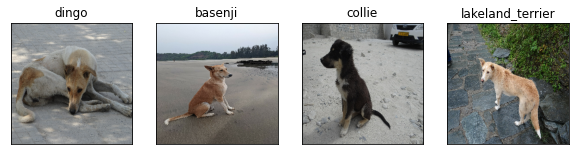

In [ ]:
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)